In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2021-08-10 09:32:31--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  33.0MB/s    in 2.5s    

2021-08-10 09:32:34 (33.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
pre_trained_model=InceptionV3(
    include_top=False,
    input_shape=(150,150,3),
    weights=None,
                              )

In [6]:
pre_trained_model.load_weights(local_weights_file)

In [7]:
for layer in pre_trained_model.layers:
  layer.trainable=False

In [8]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output =last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [11]:
from tensorflow.keras.optimizers import RMSprop

x=layers.Flatten()(last_output)
x=layers.Dense(1024,activation='relu')(x)
x=layers.Dropout(0.2)(x)                  
x=layers.Dense(1,activation='sigmoid')(x)           

model = Model(pre_trained_model.input,x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

--2021-08-10 09:32:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   157MB/s    in 0.9s    

2021-08-10 09:32:39 (157 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [13]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

--2021-08-10 09:32:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-or-human.zip’

/tmp/validation-hor 100%[===================>]  10.95M  --.-KB/s    in 0.1s    

2021-08-10 09:32:39 (102 MB/s) - ‘/tmp/validation-horse-or-human.zip’ saved [11480187/11480187]



In [14]:
local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [15]:
train_dir='/tmp/training'
validation_dir='/tmp/validation'

train_horses_dir=os.path.join(train_dir,'horses')
train_humans_dir=os.path.join(train_dir,'humans')
validation_horses_dir=os.path.join(validation_dir,'horses')
validation_humans_dir=os.path.join(validation_dir,'humans')

train_horses_fnames=os.listdir(train_horses_dir)
train_humans_fnames=os.listdir(train_humans_dir)
validation_horses_fnames=os.listdir(validation_horses_dir)
validation_humans_fnames=os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_dir))
print(len(validation_humans_dir))

500
527
22
22


In [16]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
) 

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [17]:
callbacks = myCallback()
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=10,
      callbacks=[callbacks]
      )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 12s 308ms/step - loss: 1.0606 - accuracy: 0.7200 - val_loss: 0.0693 - val_accuracy: 0.9800
Epoch 2/10
10/10 [==============================] - 2s 196ms/step - loss: 0.2081 - accuracy: 0.9200 - val_loss: 0.0437 - val_accuracy: 0.9800
Epoch 3/10
10/10 [==============================] - 2s 235ms/step - loss: 0.0625 - accuracy: 0.9691 - val_loss: 0.0478 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 2s 191ms/step - loss: 0.1060 - accuracy: 0.9700 - val_loss: 0.0359 - val_accuracy: 0.9800
Epoch 5/10
10/10 [==============================] - 2s 189ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000

Reached 99.9% accuracy so cancelling training!


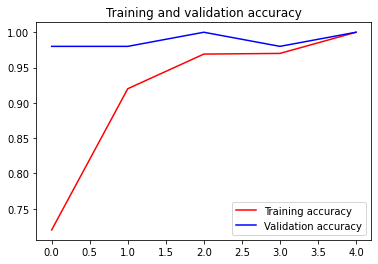

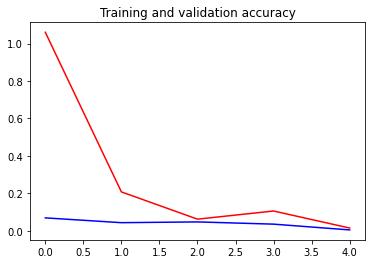

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')

plt.show()